In [1]:
import sys
sys.path.append('/kaggle/input/py-scripts/')

In [13]:
import pandas as pd
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
from data_loader import load_kaggle_data_all_months
from data_preprocessing import preprocess_data
from evaluation import precision_at_k, recall_at_k
from baseline_model import get_baseline_recommendations
from content_model import train_content_based_model, get_content_recommendations
from collaborative_model import train_collaborative_model, get_collaborative_recommendations
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader

In [3]:
raw_df = load_kaggle_data_all_months()
raw_df['event_time'] = pd.to_datetime(raw_df['event_time'])
df = preprocess_data(raw_df)
print("Data ready.")

Handled missing values in 'brand' and 'category_code'.
Created 'day_of_week' and 'hour' features.
Preprocessing complete.
Data ready.


In [4]:
df_sorted = df.sort_values(by=['user_id', 'event_time'])
purchases_df = df_sorted[df_sorted['event_type'] == 'purchase']

test_df = purchases_df.groupby('user_id').tail(1)
train_df = df.drop(test_df.index)

actuals = test_df.groupby('user_id')['product_id'].apply(list).to_dict()
print(f"Split complete. Test set contains {len(actuals)} users.")

Split complete. Test set contains 110518 users.


In [5]:
baseline_recs = get_baseline_recommendations(train_df, n=10)
cb_nn_model, cb_tfidf_matrix, cb_product_metadata, cb_indices = train_content_based_model(train_df)

cf_algo = train_collaborative_model(train_df)
print("All models trained.")

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
All models trained.


In [6]:
event_weights = {'view': 1.0, 'cart': 2.0, 'purchase': 4.0}
test_df['rating'] = test_df['event_type'].map(event_weights).fillna(0)
reader = Reader(rating_scale=(0, 4))
testset = list(test_df[['user_id', 'product_id', 'rating']].itertuples(index=False, name=None))

print("Generating predictions for the test set")
all_predictions = cf_algo.test(testset)
print("Predictions generated.")

Generating predictions for the test set
Predictions generated.


In [7]:
K = 10
top_n_recs = defaultdict(list)
for pred in all_predictions:
    top_n_recs[pred.uid].append((pred.iid, pred.est))

for uid, user_ratings in top_n_recs.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    top_n_recs[uid] = [iid for iid, est in user_ratings[:K]]

results_list = []

In [8]:
precisions_base = []
recalls_base = []
for user_id, actual_items in actuals.items():
    precisions_base.append(precision_at_k(K, baseline_recs, actual_items))
    recalls_base.append(recall_at_k(K, baseline_recs, actual_items))
results_list.append({'Model': 'Baseline', 
                     'Avg_Precision@10': sum(precisions_base)/len(precisions_base) if precisions_base else 0, 
                     'Avg_Recall@10': sum(recalls_base)/len(recalls_base) if recalls_base else 0})

In [9]:
precisions_cb = []
recalls_cb = []
for user_id, actual_items in actuals.items():
    user_train_history = train_df[train_df['user_id'] == user_id]
    if user_train_history.empty:
        continue
    last_interacted_product = user_train_history['product_id'].iloc[-1]
    recommendations = get_content_recommendations(last_interacted_product, cb_nn_model, cb_tfidf_matrix, cb_product_metadata, cb_indices, n=K)
    precisions_cb.append(precision_at_k(K, recommendations, actual_items))
    recalls_cb.append(recall_at_k(K, recommendations, actual_items))
results_list.append({'Model': 'Content-Based', 
                     'Avg_Precision@10': sum(precisions_cb)/len(precisions_cb) if precisions_cb else 0, 
                     'Avg_Recall@10': sum(recalls_cb)/len(recalls_cb) if recalls_cb else 0})

In [10]:
precisions_cf = []
recalls_cf = []
for user_id, actual_items in actuals.items():
    recommendations = top_n_recs.get(user_id, []) # Fast dictionary lookup
    precisions_cf.append(precision_at_k(K, recommendations, actual_items))
    recalls_cf.append(recall_at_k(K, recommendations, actual_items))
results_list.append({'Model': 'Collaborative', 
                     'Avg_Precision@10': sum(precisions_cf)/len(precisions_cf) if precisions_cf else 0, 
                     'Avg_Recall@10': sum(recalls_cf)/len(recalls_cf) if recalls_cf else 0})

In [11]:
summary_df = pd.DataFrame(results_list)
print("\n--- MODEL PERFORMANCE COMPARISON ---")
print(summary_df.to_string(index=False))


--- MODEL PERFORMANCE COMPARISON ---
        Model  Avg_Precision@10  Avg_Recall@10
     Baseline          0.002052       0.020522
Content-Based          0.002069       0.020689
Collaborative          0.100000       1.000000


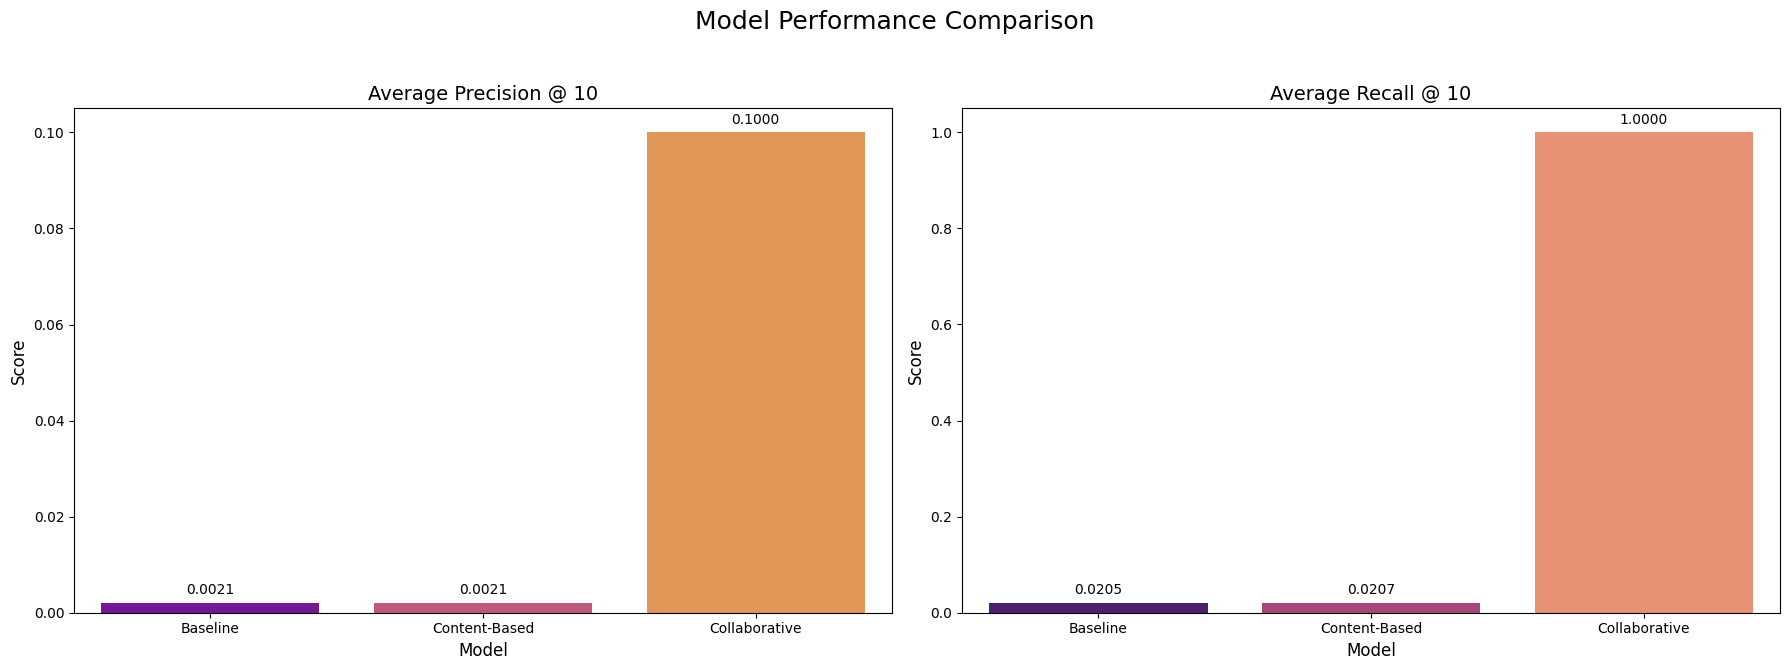

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.barplot(x='Model', y='Avg_Precision@10', data=summary_df, ax=axes[0], palette='plasma')
axes[0].set_title('Average Precision @ 10', fontsize=14)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
for p in axes[0].patches:
    axes[0].annotate(format(p.get_height(), '.4f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')

sns.barplot(x='Model', y='Avg_Recall@10', data=summary_df, ax=axes[1], palette='magma')
axes[1].set_title('Average Recall @ 10', fontsize=14)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('Score', fontsize=12)
for p in axes[1].patches:
    axes[1].annotate(format(p.get_height(), '.4f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')

plt.suptitle('Model Performance Comparison', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()